# Storing and loading data in a common format
To ease to process of comparing and elaborating the topography of surface in the last decades, several consotia have proposed standards for storing the data of profiles and surfaces.

In [1]:
from __future__ import print_function
import os 
import numpy as np
import matplotlib.pyplot as plt

# NIST reference software
The NIST provides a set of reference profiles and surfaces with computed parameters following different standards. We can find reference profiles  [2D Virtual SRM Database](https://physics.nist.gov/VSC/jsp/Database.jsp?start=0&end=40&constraint=General+Search&searchCriteria=&SearchAction=mo) and reference areal measurments
[3D Virtual SRM Database](https://physics.nist.gov/3DVSC/jsp/Database3D.jsp). For each reference profile are computed metrological parameters after different filtriations. We will test our calaculation on the reference profiles as they are "raw profiles" and onRoughness and Waviness (Lc = 0.08mm)- Calculation based on ISO 4287 and ISO 4288 Standards profiles.

In [52]:
import requests, zipfile, io
zip_file_url = r"https://physics.nist.gov/VSC/Data/Database/zip/data_195.zip"
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.filelist

[<ZipInfo filename='D_cors.sdf' compress_type=deflate file_size=89485 compress_size=25967>,
 <ZipInfo filename='D_cors.smd' compress_type=deflate file_size=97458 compress_size=26621>,
 <ZipInfo filename='surface_parameters.txt' compress_type=deflate file_size=1482 compress_size=647>,
 <ZipInfo filename='data.dtd' compress_type=deflate file_size=13945 compress_size=2904>,
 <ZipInfo filename='data.xml' compress_type=deflate file_size=91479 compress_size=27012>,
 <ZipInfo filename='data.xsl' compress_type=deflate file_size=8913 compress_size=1577>]

## The sdf file
The sdf file format is a standard file format used in surface metrology. Here we will see what it looks like.

In [98]:
sdf = z.read('D_cors.sdf')
sdfstr = str(sdf).split("\\n")
for i in range(17):
    print(sdfstr[i])

b'aNIST-1.0
ManufacID\t\t= D_cors
CreateDate\t\t= 010620090704
ModDate\t\t= 010620090704
NumPoints\t\t= 8000
NumProfiles\t\t= 1
Xscale\t\t= 0.5e-6
Yscale\t\t= 0
Zscale\t\t= 1.0e-6
Zresolution\t\t= -1.0
Compression\t\t= 0
DataType\t\t= 7
CheckType\t\t= 0
*

-1.7214
-1.7684000000000002


The file is composed by an header and the data is between two asterisks *, the first followed by a blank line. So to extract the data we will have to skip all the header until we find the blank line and skip the last line. We can build a simple importer of the .sdf file as follow:

In [4]:
def read_sdffile(sdf):
    sdffile = {}
    field1 = None
    header = 0
    while field1 is not "":
        fields = next(f).strip().split('=')
        if len(fields) > 1:
            field1,field2 = fields
            sdffile[field1.strip()] = field2
        else:
            field1,field2 = fields[0],None
            header+=1
    sdffile['data'] = np.genfromtxt(filepath,skip_footer=1,skip_header=header)
    return sdffile

In [106]:
%qtconsole

In [135]:
def read_sdfbuffer(filebuffer):
    sdfstr = iter(str(sdf).split("\\n"))
    sdffile = {}
    field1 = None
    header = 0
    while field1 is not "":
        fields = next(sdfstr).strip().split('=')
        print(fields)
        if len(fields) > 1:
            field1,field2 = fields
            sdffile[field1.strip("\\t")] = field2
        else:
            field1,field2 = fields[0],None
        header+=1
    data = []
    field2 = next(sdfstr)
    while field2 is not "*":
        data.append(np.float(field2))
        field2 = next(sdfstr)
    sdffile['data'] = np.array(data)
    return sdffile

In [5]:
myfile = read_sdfbuffer(filepath)

In [6]:
myfile.keys()

dict_keys(['ManufacID', 'CreateDate', 'ModDate', 'NumPoints', 'NumProfiles', 'Xscale', 'Yscale', 'Zscale', 'Zresolution', 'Compression', 'DataType', 'CheckType', 'data'])

In [7]:
myfile['data']

array([-0.0344, -0.0206, -0.0068, ..., -0.1636, -0.1346,  0.    ])

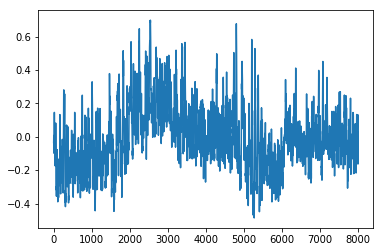

In [8]:
plt.plot(myfile['data'])

In [42]:
np.std(myfile['data'])

0.1903655190869468

In [43]:
np.average(myfile['data'])

3.8745156855791214e-07

In [44]:
np.max(myfile['data'])

0.6974

However, it is not handy to compare all the reference values with our calculation in this way. So we will take advantage of the xml file provided by NIST.
## The xml version
From our zip file we extract the data.xml file and we print it.

In [198]:
sdfxml = z.read('data.xml')
print(sdfxml)

bytes

In [199]:
from lxml import etree,objectify
xmltree = etree.fromstring(sdfxml)

To get an insight on the structure of the xml file we define a recursive function for prining the moduels

In [200]:
def prettyprint(obj,currentlevel=0):
    for i in obj:
        print("  "*currentlevel+str(i.tag))
        prettyprint(i,currentlevel+1)

In [201]:
prettyprint(xmltree)

PART
  PART_NAME
  PART_DATE
  PART_MANUFACTURER
  PART_DESCRIPTION
PROCESS
  PROCESS_NAME
MEASUREMENT
  MEASUREMENT_INSTRUMENT_TYPE
DATAFILE
  FILENAME
  UNITS
  NUMPOINTS
  SPACING
  KCAL
  DATA_TYPE
  DATA_POINT_VALUES
ANALYSIS
  CURVATURE_REMOVAL
    LSQ_COEFF
  FILTER
    FILTER_TYPE
    LONG_CUTOFF
    UNITS
    METHOD
    SHORT_CUTOFF_PROFILE
      SHORT_CUTOFF_PROFILE_SURFACE_PARAMETERS
        PA
        PQ
        PSK
        PKU
        PZ
        PDq
        PSm
        Pc
        Pt
        Pp
        Pv
        UNITS
        SM_SETTING
        PC_SETTING
      SHORT_CUTOFF_PROFILE_NUMBPOINTS
      SHORT_CUTOFF_PROFILE_DATA_POINT_VALUES
    LSQ_REMOVED_PROFILE
    RAW_PROFILE
      RAW_PROFILE_SURFACE_PARAMETERS
        PA
        PQ
        PSK
        PKU
        PZ
        PDq
        PSm
        Pc
        Pt
        Pp
        Pv
        UNITS
        SM_SETTING
        PC_SETTING
    ROUGHNESS
      ROUGHNESS_SURFACE_PARAMETERS
        RA
        RQ
        RSK
     

We can see that the files contains for each profile its parameters, we are now interest in RAW parameters. For accessing the easely we use the objectify function of lxml module. The data are in DATAFILE.DATA_POINT_VALUES.

In [264]:
g = objectify.fromstring(sdfxml)
datastr = g.DATAFILE.DATA_POINT_VALUES
rawparams = g.ANALYSIS.FILTER.RAW_PROFILE.RAW_PROFILE_SURFACE_PARAMETERS
spacing = float(g.DATAFILE.SPACING)
numpoints = int(g.DATAFILE.NUMPOINTS)
print("Spacing: %s Num. points: %s" %(spacing,numpoints))

Spacing: 0.5 Num. points: 8000
[0.00000000e+00 5.00125016e-01 1.00025003e+00 ... 3.99949975e+03
 3.99999987e+03 4.00050000e+03]


array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 3.9985e+03, 3.9990e+03,
       3.9995e+03])

The datastr is a string object so we have to convert it to an array so that we can use it for latter processing. In this case the last value is a whitespace we have to ignore it.

In [245]:
data = np.array(datastr.text.split('\n')[:-1],dtype=np.float)
results = {}

In [249]:
np.linspace(0,numpoints*spacing,spacing)

array([], dtype=float64)

Text(0, 0.5, 'um')

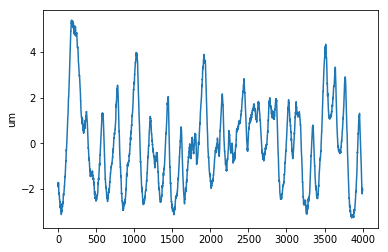

In [266]:
plt.plot(np.arange(0,numpoints)*spacing,data)
plt.ylabel(g.DATAFILE.UNITS)

In [231]:
cal = np.std(data)
ref = rawparams.PQ
results['PQ'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 1.8537462086822432 Reference: 1.85375 Error: :3.7913177568515977e-06


In [233]:
cal = np.average(np.abs(data))
ref = rawparams.PA
results['PA'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 1.50006325 Reference: 1.50006 Error: :-3.250000000010189e-06


In [235]:
from scipy import stats
cal = stats.kurtosis(data,fisher=False)
ref = rawparams.PKU
results['PKU'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 2.870416074414996 Reference: 2.87041 Error: :-6.074414995893562e-06


In [236]:
cal = stats.skew(data)
ref = rawparams.PSK
results['PSK'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 0.46146583806376545 Reference: 0.46146 Error: :-5.838063765473134e-06


In [267]:
# Maximum profile valley
cal = abs(np.min(data))
ref = rawparams.Pv
results['Pv'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 3.2626 Reference: 3.2626 Error: :0.0


In [269]:
# Maximum profile peak
cal = abs(np.max(data))
ref = rawparams.Pp
results['Pp'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 5.3837 Reference: 5.3837 Error: :0.0


In [239]:
cal = abs(np.min(data)) + abs(np.max(data))
ref = rawparams.PZ
results['PZ'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 8.6463 Reference: 8.6463 Error: :0.0


In [240]:
cal = abs(np.min(data)) + abs(np.max(data))
ref = rawparams.Pt
results['Pt'] = (cal,ref)
print("Calculated: %s Reference: %s Error: :%s" %(cal,ref,ref-cal))

Calculated: 5.3837 Reference: 8.6463 Error: :3.2626


In [270]:
from scipy.signal import find_peaks
find_peaks